In [1]:
import warnings
import cufflinks
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras import optimizers
from keras.layers import Dense
from keras.utils import to_categorical
from keras.models import Sequential, Model
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

%matplotlib inline
warnings.filterwarnings("ignore")
cufflinks.go_offline(connected=True)

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(0)
seed(0)

Using TensorFlow backend.


### Load data

In [2]:
train = pd.read_csv('../input/X_train.csv')
labels = pd.read_csv('../input/y_train.csv')
test = pd.read_csv('../input/X_test.csv')

### Join train features with labels

In [3]:
train = train.join(labels, on='series_id', rsuffix='_')
train.drop('series_id_', axis=1, inplace=True)
print(train.shape)
display(train.head())

(487680, 15)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,group_id,surface
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,13,fine_concrete
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,13,fine_concrete
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,13,fine_concrete
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,13,fine_concrete
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,13,fine_concrete


### Pre process the labels

In [4]:
target = train['surface']
n_labels = target.nunique()
labels_names = target.unique()
le = LabelEncoder()
target = le.fit_transform(target.values)
target = to_categorical(target)
train.drop('surface', axis=1, inplace=True)

### Train/validation split

In [5]:
features = ['orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W', 
            'angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z', 
            'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z']

X_train, X_val, Y_train, Y_val = train_test_split(train[features], target, test_size=0.2, random_state=0)
print('Train shape', X_train.shape)
print('Validation shape', X_val.shape)
display(X_train.head())

Train shape (390144, 10)
Validation shape (97536, 10)


,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
174517,-0.22351,0.96262,0.147250,-0.041492,-0.023037,0.107670,-0.313830,0.016821,3.8752,-11.1430
434895,-0.54943,-0.82225,-0.127320,-0.076376,0.356350,-0.165830,0.212980,1.202700,11.1940,-7.9759
385247,0.78303,0.60372,0.097223,0.113750,0.064847,0.148310,-0.374690,-0.033998,2.8156,-10.2200
374689,0.92600,0.34640,0.059994,0.137600,0.096735,-0.049043,0.144260,-0.457680,3.9749,-5.1218
297812,-0.66945,-0.72716,-0.115300,-0.098892,0.215470,-0.010674,0.022843,1.427000,6.0013,-9.4340


### Model

In [6]:
epochs = 100
batch = 128
lr = 0.001
adam = optimizers.Adam(lr)

In [7]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(n_labels, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer=adam)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1408      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 585       
Total params: 10,249
Trainable params: 10,249
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model.fit(X_train.values, Y_train, validation_data=(X_val.values, Y_val), epochs=epochs, verbose=2)

Train on 390144 samples, validate on 97536 samples
Epoch 1/100
 - 37s - loss: 1.2016 - val_loss: 0.8861
Epoch 2/100
 - 35s - loss: 0.7857 - val_loss: 0.7134
Epoch 3/100
 - 38s - loss: 0.6580 - val_loss: 0.6215
Epoch 4/100
 - 35s - loss: 0.5948 - val_loss: 0.5758
Epoch 5/100
 - 36s - loss: 0.5578 - val_loss: 0.5672
Epoch 6/100
 - 35s - loss: 0.5351 - val_loss: 0.5246
Epoch 7/100
 - 37s - loss: 0.5185 - val_loss: 0.5084
Epoch 8/100
 - 36s - loss: 0.5068 - val_loss: 0.5213
Epoch 9/100
 - 37s - loss: 0.4953 - val_loss: 0.4975
Epoch 10/100
 - 35s - loss: 0.4872 - val_loss: 0.4864
Epoch 11/100
 - 35s - loss: 0.4784 - val_loss: 0.4957
Epoch 12/100
 - 37s - loss: 0.4722 - val_loss: 0.4945
Epoch 13/100
 - 35s - loss: 0.4652 - val_loss: 0.4657
Epoch 14/100
 - 36s - loss: 0.4592 - val_loss: 0.4629
Epoch 15/100
 - 36s - loss: 0.4538 - val_loss: 0.4477
Epoch 16/100
 - 36s - loss: 0.4481 - val_loss: 0.4433
Epoch 17/100
 - 36s - loss: 0.4434 - val_loss: 0.4437
Epoch 18/100
 - 37s - loss: 0.4374 - val

#### Model loss plot

In [9]:
history_pd = pd.DataFrame.from_dict(history.history)
history_pd.iplot(kind='line')

#### Model evaluation

In [10]:
train_pred = model.predict_classes(X_train)
val_pred = model.predict_classes(X_val)
Y_train = np.argmax(Y_train, axis=1)
Y_val = np.argmax(Y_val, axis=1)

print('Train accuracy', accuracy_score(Y_train, train_pred))
print('Validation accuracy', accuracy_score(Y_val, val_pred))

Train accuracy 0.911742843667979
Validation accuracy 0.9100947342519685


#### Model confusion matrix

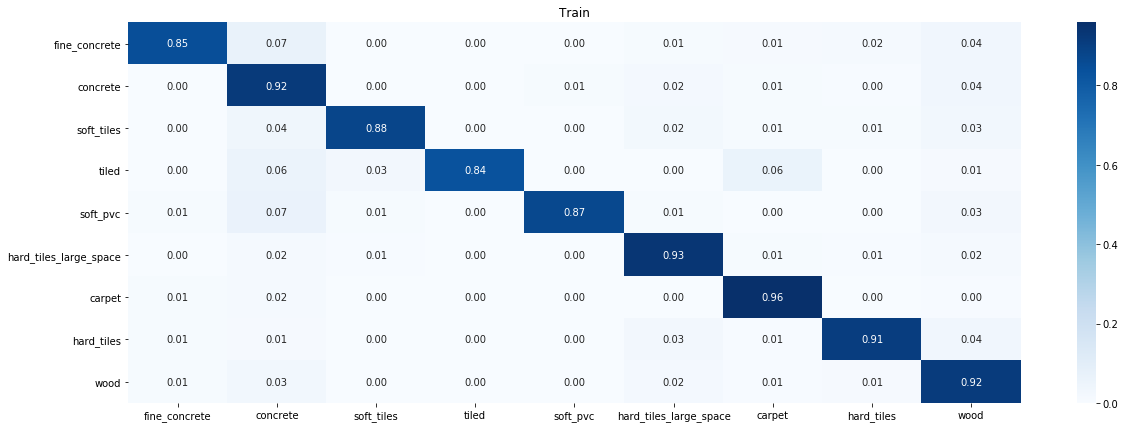

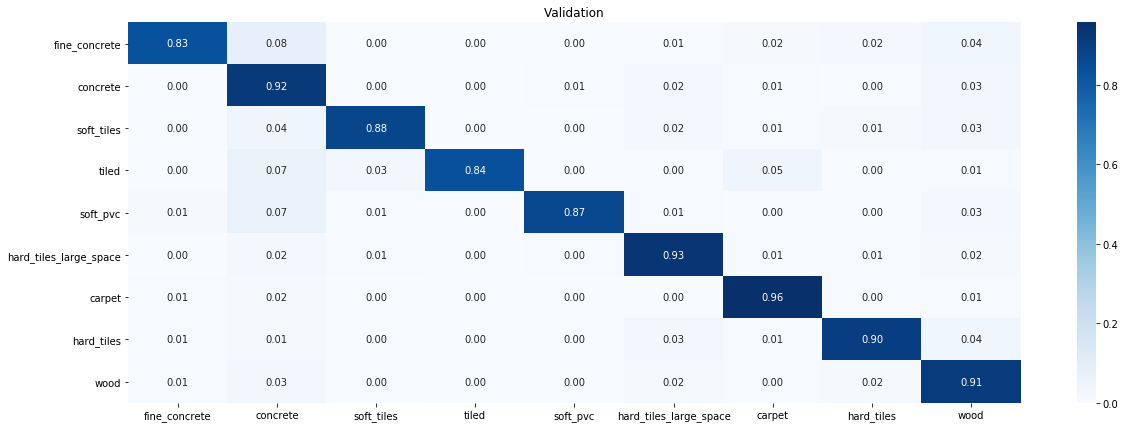

In [11]:
cnf_matrix = confusion_matrix(Y_train, train_pred)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels_names, columns=labels_names)

plt.figure(figsize=(20, 7))
ax = plt.axes()
ax.set_title('Train')
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax)
plt.show()

cnf_matrix = confusion_matrix(Y_val, val_pred)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels_names, columns=labels_names)

plt.figure(figsize=(20, 7))
ax = plt.axes()
ax.set_title('Validation')
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax)
plt.show()

### Test predictions

In [ ]:
predictions = model.predict_classes(test[features].values)
test['surface'] = le.inverse_transform(predictions)
df = test[['series_id', 'surface']]
df = df.groupby('series_id', as_index=False).agg(lambda x:x.value_counts().index[0])
df.to_csv('submission.csv', index=False)
df.head(10)